# Simulating a Radio Interferometer 
## Joel Miller - 9469334
References: 
- https://web.njit.edu/~gary/728/
- https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview
- http://www-astro.physics.ox.ac.uk/~ianh/3GC3_sims/3/entry-20130203-135540/index.html


In this notebook we will detail the steps necessary to simulate how the VLA in D-configuration will respond to two point sources. The point sources are as follows:  

Source 1: 
- Position: J 05 00 00 +45 00 00
- Flux Density: 3.6 Jy

Source 2:
- Position J 05 00 10 +45 03 00
- Flux density: 5.8 Jy

We can begin by importing the antenna positions for the VLA in D-configuration.
The positions are measured as time for light to travel from an antenna to the centre of the VLA array; therfore, we must also convert these time values into distances.

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt


dconfig = np.loadtxt('d_config.txt')
c = 3*10**8                                     # Speed of light ms-1

# Extract xyz values from data columns
x_dcon = dconfig[:, 0]                          # Measured in nano seconds
y_dcon = dconfig[:, 1]                          # Measured in nano seconds
z_dcon = dconfig[:, 2]                          # Measured in nano seconds

# Convert to metres
x = c*x_dcon*1*10**(-9)                         # Position in metres
y = c*y_dcon*1*10**(-9)                         # Position in metres
z = c*z_dcon*1*10**(-9)                         # Position in metres
q = np.sqrt((z**2)+(x**2))                     

We can now plot the positions of each antenna to visualise the VLA in D configuration 

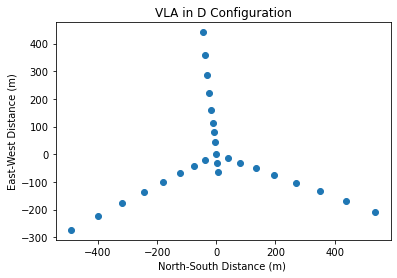

In [2]:
plt.scatter(y, z)
plt.title('VLA in D Configuration')
plt.xlabel('North-South Distance (m) ')
plt.ylabel('East-West Distance (m)')
plt.show()

Now we know the positions of the antennas we can calculate the maximum baseline length for use when calculating the resolution of the interferometer. Looking at the configuration we can see that there could be three possibilities for maximum baseline length. We will calculate these and see which is largest.  

In [3]:
# Point 1
y_min = min(y)
y_min_index = np.where(y == y_min)
z_y_min = z[y_min_index]

# Point 2
z_max = max(z)
z_max_index = np.where(z == z_max)
y_z_max = y[z_max_index]

# Point 3
y_max = max(y)
y_max_index = np.where(y == y_max)
z_y_max = z[y_max_index]

max_baseline_1 = math.sqrt((y_max - y_min)**2 + (z_y_max - z_y_min)**2)
max_baseline_2 = math.sqrt((y_max - y_z_max)**2 + (z_y_max - z_max)**2)
max_baseline_3 = math.sqrt((y_min - y_z_max)**2 + (z_y_min - z_max)**2)

print('Baseline 1 is', round(max_baseline_1,2))
print('Baseline 2 is', round(max_baseline_2,2))
print('Baseline 3 is', round(max_baseline_3,2))

Baseline 1 is 1030.83
Baseline 2 is 872.87
Baseline 3 is 841.78


We see that baseline 1 is the longest at 1030.83m. 

# Observing parameters 

In [4]:
# Observing parameters
n = len(x)                                      # Number of antennas
d = 25                                          # Diameter of 1 antenna 
pos = (n*(n-1))/2                               # Number of baselines
v = 5*10**9                                     # Frequency
lam = c/v                                       # Wavelength

# Creating an Image of The True Sky

## 
Now that we know know the geometry of the VLA we can create an image of the section of sky which we wish to map. 
We know that each antenna has a diameter of 25m; therefore, we can work out the field of view using the equation 
$$ FOV = \frac{\lambda}{d} $$
Where $\lambda$ is the observing wavlength and $d$ is the diameter of the dish. 
This resultis in a field of view with a width of ${2.4}$x${10^-3}$ rad 
We can also calculate the resolution of the array using the equation 
$$ \theta = \frac{\lambda}{D} $$ 
This time $\ D$ is the maximum basline length, $1030$ m, and this gives a resolution of ${5.82}$x${10^-5}$ rad  
If we converet the field of view and the resolution from radians to arcseconds, we get a field of view that is 495 arcseconds across and a resolution of 12 arcseconds.

To ensure that the sky is not undersampled it is sensible to choose a pixel size that is at least half as small as the resolution.
Here we have chosen to make the pixel size a quarter the size of the resolution. This means that one pixel is 3 arcseconds wide. 

For a field of view of 495 arcseconds, this means the image must be at least $ \frac{495}{3}$ pixels wide, i.e. 165 pixels wide.
Here we have chosen to make the image 256 pixels wide to ensure that the entire field of view is contained within the image.

## Set the Image Parameters

In [5]:
data = np.loadtxt('point_source.txt')   # load 'source information'

res = lam/max_baseline_1                # Calculate resolution of VLA in D config           
res = res*3600*180/np.pi                # Convert resolution from rad to arcseconds
nyq = 4                                 # Split resolution in to 4 pixels
pixel_s = res/nyq                       # Calculate size of individual pixel
fov_rad = lam/d                         # Calculate FOV of VLA
fov = fov_rad*3600*180/np.pi            # Convert FOV from radians to arcseconds
pixels_fov = fov/pixel_s                # Calculate width of FOV in pixels
print('Pixel size is', pixel_s, 'arcseconds')
print('Field of view in pixels is ',pixels_fov)
fov_d = fov/pixel_s
fov_r = fov_d/2


pixels = 256                               # Set width of image in pixels 
x1 = y1 = np.arange(0, pixels, 1)          # Create x and y values from 0 
                                           # to pixels with spacing 1
xx, yy = np.meshgrid(x1, y1)               # Meshgrid to create xx & yy pixel 
                                           # by pixel grid
a = np.zeros((pixels, pixels))             # Initialise a with size pixels by pixels
print('Width in pixels is',pixels)

imsize = pixels*pixel_s
print('Image covers a field of view of', imsize, 'arcseconds')
extent1 = imsize/120
print('Extent of image ranges from', -extent1, 'to', extent1 )

extent1=[-extent1, extent1, -extent1, extent1]  # Define the extent of the fov   



Pixel size is 3.0014361111430543 arcseconds
Field of view in pixels is  164.9328910101318
Width in pixels is 256
Image covers a field of view of 768.3676444526219 arcseconds
Extent of image ranges from -6.403063703771849 to 6.403063703771849


## Converting RA and Dec of Sources Into Pixel Values 
To start we convert Ra and Declination into arcseconds. We can then calculate the relative positions of the sources in arcseconds, and convert these relative positions into pixel positions. Here source one is positioned at the centre of the field of view.

In [6]:
ra_arcsec = []
dec_arcsec = []
for point in data:                               # loop over each source in data file
    h, m, s, deg, arcmin, arcsec, jy = point     # define variables in data file

    # Convert RA to arcsec
    h_arcsec = h*3600*15*np.cos(np.radians(45))
    m_arcsec = m*60*15*np.cos(np.radians(45))
    s_arcsec = s*15*np.cos(np.radians(45))
    ra_arcsec.append(h_arcsec + m_arcsec + s_arcsec)

    # Convert DEC to arc sec
    deg_arcsec = deg*3600
    arcmin_arcsec = arcmin*60
    arcsec = arcsec
    dec_arcsec.append(deg_arcsec + arcmin_arcsec + arcsec)

point1 = [(ra_arcsec[0]-ra_arcsec[0]), (dec_arcsec[0]-dec_arcsec[0])]
point2 = [(ra_arcsec[0]-ra_arcsec[1]), (dec_arcsec[1]-dec_arcsec[0])]


# Convert arcsesond position to pixel position
centre= 0.5*(pixels+1)
point1 = list(centre + (np.asarray(point1))/pixel_s)
point2 = list(centre + (np.asarray(point2))/pixel_s)

sources = np.ones((2,3))
sources[0,0]=round(point1[0])
sources[0,1]=round(point1[1])
sources[1,0]=round(point2[0])
sources[1,1]=round(point2[1])
sources[0,2]= (data[0,6])
sources[1,2]= (data[1,6])

[0.0, 0.0]
[-106.06601717797457, 180.0]


[[128.  128.    3.6]
 [ 93.  188.    5.8]]


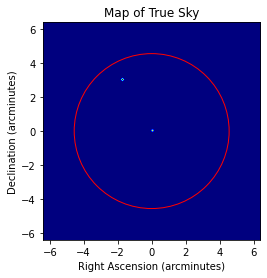

In [7]:
print(sources)

for point in sources:                                  # loop over each source in data file
    x1, y1, b = point                                  # define variables in data file
    r = np.sqrt(((x1 - xx) ** 2) + ((y1 - yy) ** 2))   # calculate distance from source 
    a += b * (np.exp(-1*r**2))                         # define value of each pixel 
    

plt.imshow(a, cmap='jet', interpolation='nearest', origin='lower', extent=extent1)
plt.title('Map of True Sky')
plt.xlabel('Right Ascension (arcminutes)')
plt.ylabel('Declination (arcminutes)')
plt.scatter([0], [0], s=24000, edgecolor='red', facecolor='none')
plt.show()

The red circle represents the extent of the Field-of-view of.

# Calculating The Primary Beam 
The primary beam describes the sensitivity of an antenna . An antenna is most sensitive towards the centre of the dish with sensitivty dropping towards the edges. Here we have described the primary beam as a gaussian with a value of 1 at the centre and a value of 0.5 at the edge of the field of view. This means that a source with a flux of 1 mJy would be measeured to have a flux of 1mJy at the centre of the beam, but only 0.5mJy at the edge of the beam.
The primary beam has a width equivalent to the field of view of the VLA, of 495 arcseconds. 

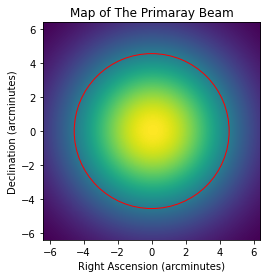

In [8]:
radius = pixels_fov/2
sig = np.sqrt((radius**2)/(-2*np.log(0.5)))

gauss = np.zeros((1, 3))
gauss[0,0] = (point1[0])
gauss[0,1] = (point1[1])
gauss[0,2] = sig

g = np.zeros((pixels, pixels))

for point in gauss:                                  # loop over each galaxy in data file
    x2, y2, sig = point                              # define variables in data file
    r = np.sqrt(((x2 - xx) ** 2) + ((y2 - yy) ** 2)) # calculate distance from source
    g = np.exp(-r**2/(2*sig**2))                     # values for each pixel
    
    

#%matplotlib widget
plt.imshow(g, origin='lower', extent=extent1)
plt.title('Map of The Primaray Beam')
plt.xlabel('Right Ascension (arcminutes)')
plt.ylabel('Declination (arcminutes)')
plt.scatter([0], [0], s=24000, edgecolor='red', facecolor='none')
plt.show()

The red circle represents the coverage of the primary beam.


We can multiply the primary beamby the true sky to simulate how the VLA would see the sky. 

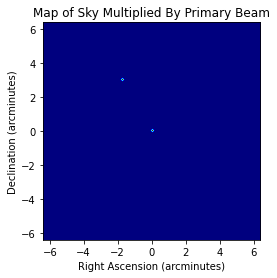

In [9]:
gauss_sky =  a * g
#%matplotlib widget
plt.imshow(gauss_sky, cmap='jet', interpolation='nearest', origin='lower', extent = extent1)
plt.title('Map of Sky Multiplied By Primary Beam')
plt.xlabel('Right Ascension (arcminutes)')
plt.ylabel('Declination (arcminutes)')
plt.show()


# Calculating Hour Angles
Since our observation lasts for one hour and a we sample every 30s this means we can have 121 samples.
Given that 1 hour angle is equal to 15° we can define each hourangle using the linspace function. 

In [10]:
# Define hour angle & declination

s = 121                                         # Intervals
ha = np.radians(np.linspace(-7.5, 7.5, s))      # 1 hour of angle = 15 degrees
dec = np.radians(45)                            # Declination of pointing centre 

Now we know all hour angles for which we will sample the sources, we can start to calculate U, V & W  for all baselines and all hour angles. To do this we first need to calculate all the differences in the x, y & z coordinates for the 27 antenneas. 



In [11]:
# Define Arrays to fill
x_diff = np.zeros((n, n))          # Differnces in x values
y_diff = np.zeros((n, n))          # Differnces in y values
z_diff = np.zeros((n, n))          # Differnces in z values
xyz = []

# Calculate xyz for all baselines
for i in range(n):
    for j in range(n):
        if i < j:
            x_diff[i, j] = (x[j] - x[i])                           # X differences
            y_diff[i, j] = (y[j] - y[i])                           # Y differences
            z_diff[i, j] = (z[j] - z[i])                           # Z differences
            xyz.append([x_diff[i, j], y_diff[i, j], z_diff[i, j]]) # Append difference

# Convert to numpy array        
xyz = np.array(xyz)   

# Split into individual x, y and z
X = xyz[:, 0]                                                      
Y = xyz[:, 1]
Z = xyz[:, 2]

We can calculate UVW using the following matrix multiplaction and plot the results to give a visual representation of the UV coverage. 

\begin{equation}\label{eq:matrixeqn}
     \begin{pmatrix}
       U \\
       V \\
       W
     \end{pmatrix}
     =
     \frac{1}{\lambda}
     \begin{pmatrix}
       sinH_0 & cosH_0 & 0 \\
       -sin\delta_0 cosH_0 & sin\delta_0 sinH_0 & cos\delta_0 \\
       cos\delta_0 cosH_0 & -cos\delta_0 sinH_0 & sin\delta_0
     \end{pmatrix}
     \begin{pmatrix}
       X \\
       Y \\
       Z
     \end{pmatrix}
   \end{equation}
 

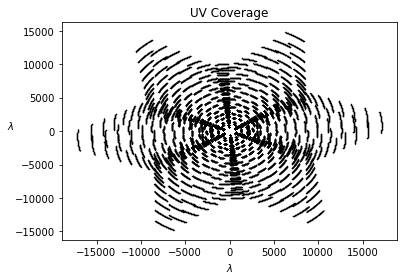

In [12]:
# Define Arrays to fill
u = np.zeros((int(pos), s))
v = np.zeros((int(pos), s))
w = np.zeros((int(pos), s))

# Calulate 
for i in range(int(pos)):
    u[i, :] = lam ** (-1) * (np.sin(ha) * X[i] + np.cos(ha) * Y[i])
    v[i, :] = lam ** (-1) * (-np.sin(dec) * np.cos(ha) * X[i] +
                             np.sin(dec) * np.sin(ha) * Y[i] + np.cos(dec) * Z[i])

# Plot the UV coverage
plt.scatter(u , v, s=0.05, c='k')
plt.scatter(-u, -v, s=0.05, c='k')
plt.title('UV Coverage')
plt.xlabel('$\lambda$')
plt.ylabel('$\lambda$', rotation=0)
plt.show()

Once we know the position of all the U & V points we can assign a value of 1 to all UV coordinates and 0 to everywhere else.
This is called the sampling function. The sampling function must have the same number of pixels as our image for the sky; therefore, we must scale down the uv coverage to an appropriate size so that we can resample the coverage on to a grid of size pixes by pixels. 
To do this we say that 1 pixel has a size of 

$$\delta u = \frac{1}{fov_{rad}},$$

where $fov_{rad}$ is the field of view of the VLA measured in radians. This corresponds to a pixels size of 416.7 $\lambda$
Therefor we can divide all values of u and v by $\delta u$ and treat these scaled values as coordinates for where we should assign a pixel a value of 1. 

Image covers a field of view of 106666.66666666667 arcseconds
Extent of image ranges from -106.66666666666667 to 106.66666666666667


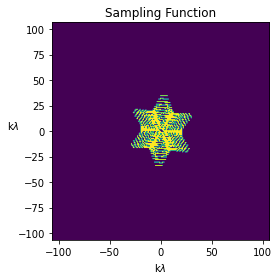

In [13]:
uv_pixels= 1/fov_rad                            # Calculate pixel size of sampling function
u_scaled = u/uv_pixels                          # Scale u value down
v_scaled = v/uv_pixels                          # Scale v value down
centre= 0.5*(pixels+1)                          # Calculate image centre
uv_image = np.zeros((pixels, pixels))           

# Fill uv_image with ones where a UV point occurs 
for i in range(s):
    uv_image[(centre+u_scaled[:, i]).astype(int),
             (centre+v_scaled[:, i]).astype(int)] = 1
    uv_image[(centre-u_scaled[:, i]).astype(int), 
             (centre-v_scaled[:, i]).astype(int)] = 1

# Calculate the extent of the uv_image
imsize = pixels*uv_pixels                                                      
print('Image covers a field of view of', imsize, 'arcseconds')
extent2 = imsize/1000
print('Extent of image ranges from', -extent2, 'to', extent2 )


extent2=[-extent2, extent2, -extent2, extent2]   # Define the extent in the uv plane  

# PLot the sampling function 
plt.imshow(uv_image, origin='lower', extent=extent2)
plt.title('Sampling Function')
plt.xlabel('k$\lambda$')
plt.ylabel('k$\lambda$', rotation=0)
plt.show()

We can take a fourier transform of the Sampling function to produce what is known as the dirty beam, or the synthesised beam.

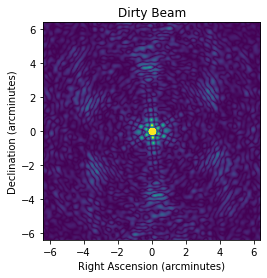

In [14]:
# Fourier transform the sampling function to get dirty beam 
fft_s = np.fft.fft2(uv_image)    
cent = np.fft.fftshift(fft_s)

# Plot the dirty beam 
plt.imshow(np.abs(cent), extent = extent1, vmin='0', vmax='350.5')
plt.title('Dirty Beam')
plt.xlabel('Right Ascension (arcminutes)')
plt.ylabel('Declination (arcminutes)')
plt.show()

If we take the fourier transform of the true sky and multiply it with the sampling function we produce what is known as the sampled visibility. 
This is what an interferometer is recording.

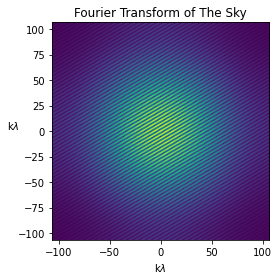

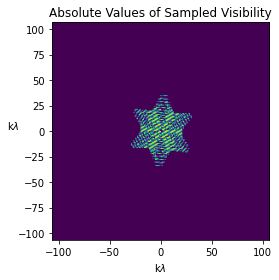

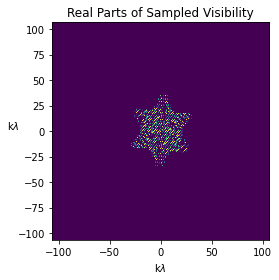

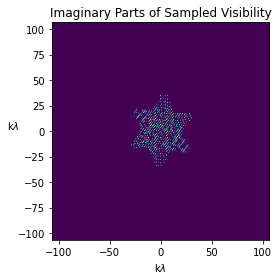

In [15]:
# Fourier transform the sky as seen by the primary beam 
fft_skymap= np.fft.fft2(gauss_sky)
fft_skymap = np.fft.fftshift(fft_skymap)

# Plot the fourier transform of the sky 
plt.imshow(np.abs(fft_skymap), origin='lower', extent = extent2)
plt.title('Fourier Transform of The Sky')
plt.xlabel('k$\lambda$')
plt.ylabel('k$\lambda$', rotation=0)
plt.show()

# Multiply the fourier transformed sky with the sampled visibility function 
s_vis=uv_image*fft_skymap

# Plot the absolute values of the sampled visibility functinos 
plt.imshow(np.abs(s_vis), origin='lower', extent = extent2)
plt.title('Absolute Values of Sampled Visibility')
plt.xlabel('k$\lambda$')
plt.ylabel('k$\lambda$', rotation=0)
plt.show()

# Plot the real parts of the sampled visibility functinos 
plt.imshow(np.real(s_vis), origin='lower', extent = extent2, vmin='0', vmax='8' )
plt.title('Real Parts of Sampled Visibility')
plt.xlabel('k$\lambda$')
plt.ylabel('k$\lambda$', rotation=0)
plt.show()

# Plot the imaginary parts of the sampled visibility functinos 
plt.imshow(np.imag(s_vis), origin='lower', extent = extent2, vmin='0', vmax='8' )
plt.title('Imaginary Parts of Sampled Visibility')
plt.xlabel('k$\lambda$')
plt.ylabel('k$\lambda$', rotation=0)
plt.show()

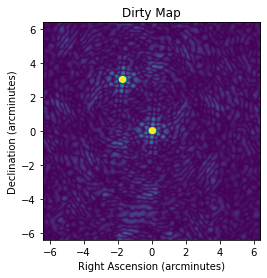

Flux density of source 1 is 3.6 Jy
Flux density of source 2 is 3.3 Jy


In [16]:
cal = 0.09375792804270133 # Calibration factor to restore flux density of sources 

# Inverse fourier transform the sampled visibility function to produce the dirty map
d_image= np.fft.ifft2(s_vis)/cal

# Plot Dirty Map
plt.imshow(np.abs(d_image), origin='lower', extent = extent1, vmin='0', vmax='1' )
plt.title('Dirty Map')
plt.xlabel('Right Ascension (arcminutes)')
plt.ylabel('Declination (arcminutes)')
plt.show()

# find largest value of d_image
print('Flux density of source 1 is', round(np.max(np.abs(d_image)),1),'Jy')

# find second largest value of d_image
flat=d_image.flatten()
flat.sort() 
print('Flux density of source 2 is',round(np.max(np.abs(flat[-2])),1),'Jy')